# ***Hand Gesture Classification***

- Đầu vào: Hình ảnh hành động của tay
- Đầu ra: dự đoán nhãn cho hành động mà tay đang làm
- Bài toán: multi-class classification (phân loại đa lớp), phân loại các hand gestures vào các lớp

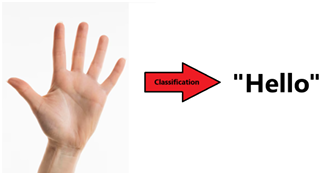

Bài toán này có thể có nhiều cách tiếp cận khác nhau.
- Nếu xét theo cách thu nhận và biểu diễn cử chỉ tay thì bài toán có thể được chia thành **skeleton based** và **box/filter-based**.

- Còn nếu xét dựa trên kỹ thuật nhận dạng, bài toán có thể chia thành cách tiếp cận **sử dụng Neural Networks** (Deep Learning Approaches) và **không dùng Neural Networks**.

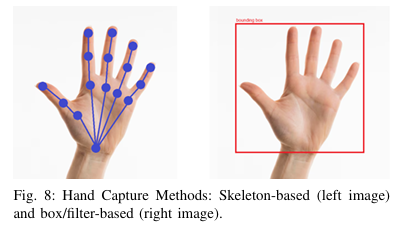


Nhóm sẽ phân tích theo 3 hướng: box/filter-based + ML, box/filter-based + DL, skeleton-based + DL

# **A. Chuẩn bị dữ liệu**

Dataset: **NUS Hand Posture Dataset 2**, gồm 2000 ảnh hand postures, 750 ảnh hand postures có nhiễu; gồm 10 lớp (classes)

In [ ]:
from PIL import Image
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys

project_path = '/content/drive/MyDrive/HandGestureRecognition'
sys.path.append(project_path)

### 1. Tải dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Tải dataset
download_path = '/content/drive/MyDrive/HandGestureRecognition/datasets'
os.makedirs(download_path, exist_ok = True)

url = 'https://www.ece.nus.edu.sg/stfpage/elepv/NUS-HandSet/NUS-Hand-Posture-Dataset-II.zip'
zip_file_name = 'NUS-Hand-Posture-Dataset-II.zip'
file_name = 'NUS-Hand-Posture-Dataset-II'
!wget -O $download_path/$file_name $url

--2025-05-16 20:52:14--  https://www.ece.nus.edu.sg/stfpage/elepv/NUS-HandSet/NUS-Hand-Posture-Dataset-II.zip
Resolving www.ece.nus.edu.sg (www.ece.nus.edu.sg)... 137.132.5.15
Connecting to www.ece.nus.edu.sg (www.ece.nus.edu.sg)|137.132.5.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77233719 (74M) [application/x-zip-compressed]
Saving to: ‘/content/drive/MyDrive/HandGestureRecognition/datasets/NUS-Hand-Posture-Dataset-II’

/content/drive/MyDr 100%[===================>]  73.66M   293KB/s    in 4m 27s  

2025-05-16 20:56:46 (282 KB/s) - ‘/content/drive/MyDrive/HandGestureRecognition/datasets/NUS-Hand-Posture-Dataset-II’ saved [77233719/77233719]



In [ ]:
# Giải nén file ZIP datatset
zip_file_path = os.path.join(download_path, file_name)
!unzip -q {zip_file_path} -d {download_path}

In [ ]:
without_noise_img_dir ='/content/drive/MyDrive/HandGestureRecognition/datasets/NUS Hand Posture dataset-II/Hand Postures'
noise_img_dir = '/content/drive/MyDrive/HandGestureRecognition/datasets/NUS Hand Posture dataset-II/Hand Postures with human noise'

In [ ]:
#Tạo dataframe
file_paths = []
labels = []

for img in os.listdir(without_noise_img_dir):
  if img.endswith(('jpg', 'jpeg', 'png')):
    first_letter = img[0]
    labels.append(img[0])
    file_paths.append(os.path.join(without_noise_img_dir, img))


for img in os.listdir(noise_img_dir):
    if img.endswith(('jpg', 'jpeg', 'png')):
      labels.append(img[0])
      file_paths.append(os.path.join(noise_img_dir, img))


In [ ]:
df = pd.DataFrame({'file_path': file_paths, 'label': labels})
df

,file_path,label
0,/content/drive/MyDrive/HandGestureRecognition/...,a
1,/content/drive/MyDrive/HandGestureRecognition/...,a
2,/content/drive/MyDrive/HandGestureRecognition/...,a
3,/content/drive/MyDrive/HandGestureRecognition/...,a
4,/content/drive/MyDrive/HandGestureRecognition/...,a
...,...,...
2745,/content/drive/MyDrive/HandGestureRecognition/...,j
2746,/content/drive/MyDrive/HandGestureRecognition/...,j
2747,/content/drive/MyDrive/HandGestureRecognition/...,j
2748,/content/drive/MyDrive/HandGestureRecognition/...,j


<ipython-input-48-917e4261286f>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, label_counts[i] + 1, str(label_counts[i]), ha='center', va='bottom')


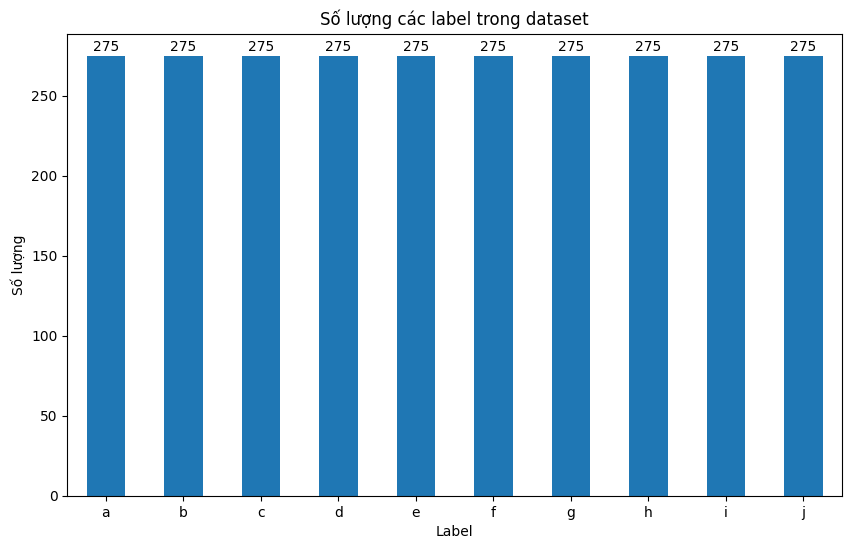

In [ ]:
# Đếm số lượng mỗi label
label_counts = df['label'].value_counts()

# Vẽ biểu đồ cột (bar chart)
plt.figure(figsize=(10, 6))
ax = label_counts.plot(kind='bar')

plt.title('Số lượng các label trong dataset')
plt.xlabel('Label')
plt.ylabel('Số lượng')
plt.xticks(rotation=0)


for i in range(len(label_counts)):
    ax.text(i, label_counts[i] + 1, str(label_counts[i]), ha='center', va='bottom')

plt.show()

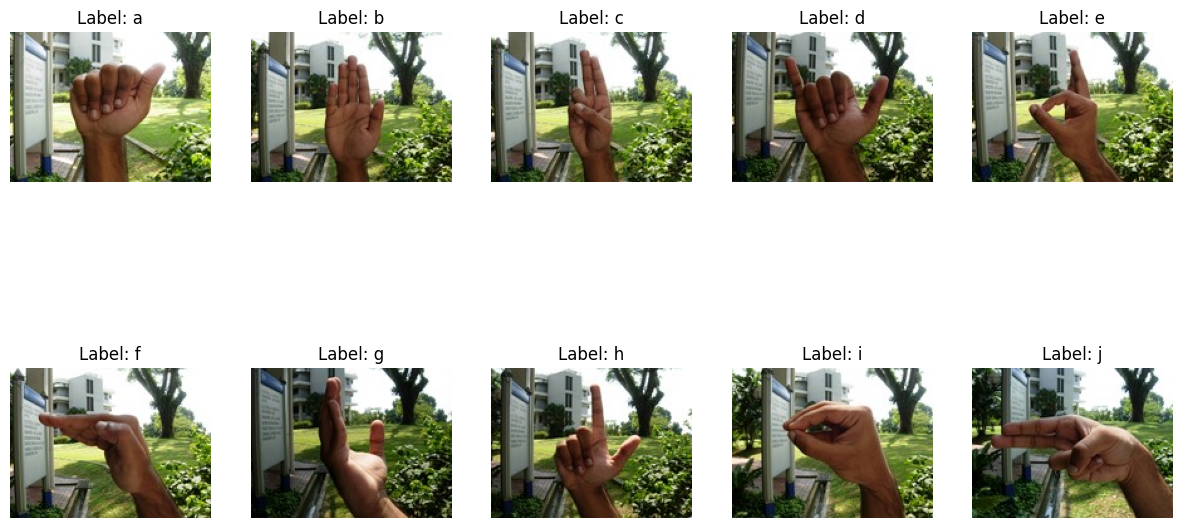

In [30]:
plt.figure(figsize=(15, 8))

# Duyệt qua từng nhãn
unique_labels = df['label'].unique()

for i, label in enumerate(unique_labels):
    # Lấy đường dẫn ảnh đầu tiên có nhãn đó
    sample_img_path = df[df['label'] == label].iloc[2]['file_path']

    # Đọc ảnh
    img = mpimg.imread(sample_img_path)

    # Hiển thị ảnh
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.show()


In [ ]:
df.to_csv(os.path.join(download_path, 'data.csv'), index=False)

### 2. Tiền xử lý

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/HandGestureRecognition/datasets/data.csv')
df

,file_path,label
0,/content/drive/MyDrive/HandGestureRecognition/...,a
1,/content/drive/MyDrive/HandGestureRecognition/...,a
2,/content/drive/MyDrive/HandGestureRecognition/...,a
3,/content/drive/MyDrive/HandGestureRecognition/...,a
4,/content/drive/MyDrive/HandGestureRecognition/...,a
...,...,...
2745,/content/drive/MyDrive/HandGestureRecognition/...,j
2746,/content/drive/MyDrive/HandGestureRecognition/...,j
2747,/content/drive/MyDrive/HandGestureRecognition/...,j
2748,/content/drive/MyDrive/HandGestureRecognition/...,j


In [ ]:
img_test = Image.open(df.iloc[0]['file_path'])
print(img_test.mode)
print(np.array(img_test).dtype)

RGB
uint8


In [ ]:
from utils.preprocessing import load_image, resize_image, normalize_pixels

Tập dữ liệu k có human noise có size là 160x120. Còn tập có human noise là 320x240. Vì vậy ta cần resize lại tập có human noise

In [ ]:
resize_image(noise_img_dir)

Resized: i_HN (4).jpg
Resized: c_HN (2).jpg
Resized: f_HN (2).jpg
Resized: c_HN (4).jpg
Resized: c_HN (3).jpg
Resized: a_HN (2).jpg
Resized: e_HN (2).jpg
Resized: f_HN (4).jpg
Resized: f_HN (1).jpg
Resized: e_HN (1).jpg
Resized: h_HN (3).jpg
Resized: d_HN (2).jpg
Resized: f_HN.jpg
Resized: d_HN.jpg
Resized: c_HN (1).jpg
Resized: b_HN (4).jpg
Resized: h_HN.jpg
Resized: g_HN (1).jpg
Resized: a_HN (3).jpg
Resized: b_HN.jpg
Resized: i_HN (1).jpg
Resized: d_HN (1).jpg
Resized: g_HN (4).jpg
Resized: b_HN (1).jpg
Resized: e_HN (4).jpg
Resized: b_HN (2).jpg
Resized: i_HN (2).jpg
Resized: d_HN (4).jpg
Resized: j_HN.jpg
Resized: h_HN (4).jpg
Resized: g_HN.jpg
Resized: h_HN (2).jpg
Resized: i_HN (3).jpg
Resized: b_HN (3).jpg
Resized: a_HN (1).jpg
Resized: e_HN (3).jpg
Resized: d_HN (3).jpg
Resized: c_HN.jpg
Resized: g_HN (3).jpg
Resized: h_HN (1).jpg
Resized: a_HN (4).jpg
Resized: g_HN (2).jpg
Resized: i_HN.jpg
Resized: a_HN.jpg
Resized: f_HN (3).jpg
Resized: e_HN.jpg
Resized: i_HN (9).jpg
Resize

### 3. Chia train, test

- Sử dụng cross validation để đánh giá. Gom thành bộ ảnh của từng người, train trên tập của người i kèm với tập noise; test trên tập của người i+1 kèm với tập noise

In [ ]:
df_clean = df.iloc[:2000].copy()  # 2000 ảnh đầu không có human noise, dữ liệu lần lượt theo từng người (VD: label a người 1, label a người 2,.....label b người 1, label b người 2,....)
df_noise = df.iloc[2000:].copy()

In [28]:
df_clean['person_id'] = df_clean.groupby('label').cumcount() + 1
df_clean[df_clean['person_id'] == 1] #In ra các ảnh của người số 1

,file_path,label,person_id
0,/content/drive/MyDrive/HandGestureRecognition/...,a,1
200,/content/drive/MyDrive/HandGestureRecognition/...,b,1
400,/content/drive/MyDrive/HandGestureRecognition/...,c,1
600,/content/drive/MyDrive/HandGestureRecognition/...,d,1
800,/content/drive/MyDrive/HandGestureRecognition/...,e,1
1000,/content/drive/MyDrive/HandGestureRecognition/...,f,1
1200,/content/drive/MyDrive/HandGestureRecognition/...,g,1
1400,/content/drive/MyDrive/HandGestureRecognition/...,h,1
1600,/content/drive/MyDrive/HandGestureRecognition/...,i,1
1800,/content/drive/MyDrive/HandGestureRecognition/...,j,1


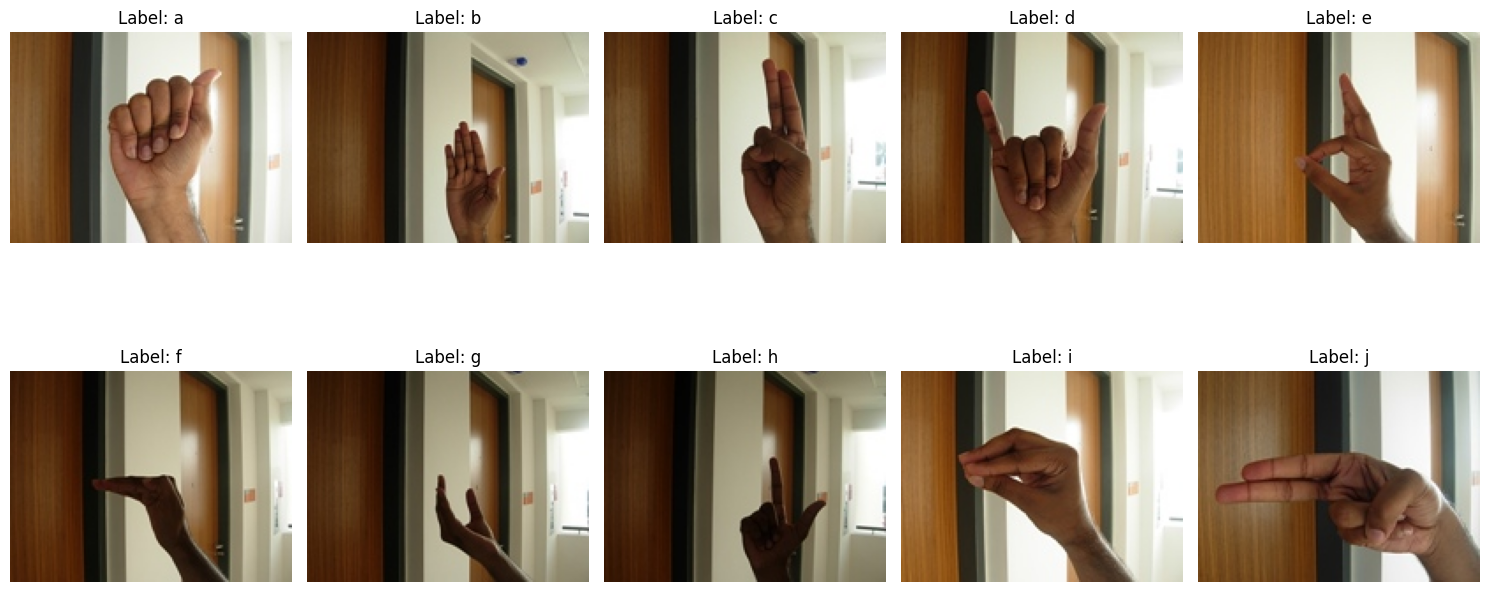

In [43]:
plt.figure(figsize=(15, 8))

person = df_clean[df_clean['person_id'] == 100].reset_index(drop=True)

# Kiểm tra xem đã gom đúng bộ ảnh theo từng người chưa
for i in range(min(10, len(person))):
    img_path = person.loc[i, 'file_path']
    label = person.loc[i, 'label']
    img = mpimg.imread(img_path)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [49]:
print(f"Số bộ ảnh (số người): {df_clean['person_id'].nunique()}")

Số bộ ảnh (số người): 200


# **B. Mô hình**

## I. Box/filter-based  - ML

Sử dụng SVM + HOG (Histogram of gradients)

## II. Box/filter-based + DL
Sử dụng mạng CNN để trích xuất đặc trưng và gán nhãn

## III. Skeleton-based + DL
Sử dụng mediapipe + MLP

#**C. So sánh kết quả, nhận xét và kểt luận**

In ra cofusion metrix, acc, f1, precision, recall

#**D. Tài liệu tham khảo**
1. Linardakis, Manousos, Iraklis Varlamis, and Georgios Th Papadopoulos. "Survey on Hand Gesture Recognition from Visual Input." arXiv preprint arXiv:2501.11992 (2025).